**This notebook introduces how to train a conditional VAE model from scratch. <br/>**
We first use an encoder to compress the high-dimensional temperature data into latent vectors. Then, we incorporate CO2 & CH4 information into latent vectors, and use an decorder to reconstruct the global temperature map.

By Weiwei Zhan

Reference: https://towardsdatascience.com/variational-autoencoders-as-generative-models-with-keras-e0c79415a7eb

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1_l2
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [2]:
cwd = os.getcwd()

train_path = os.path.join(cwd,'Data','train_val')
test_path  = os.path.join(cwd,'Data','test')

make_dir(train_path)
make_dir(test_path)

### 1. data preprocssing: prepare data for training & test sets

In [3]:
# Training set
train_files = ["historical", "ssp585", "ssp126", "ssp370","hist-GHG","hist-aer"]
X_train_xr, X_length  = prepare_predictor(train_files,train_path)
y_train_xr, y_length  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)


#### Data normalization

normalize the CO2 & CH4 time series

In [4]:
X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
                           "CH4": X_train_xr["CH4"].data
                          }, index=X_train_xr["CO2"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
                           "CH4": X_test_xr["CH4"].data
                          }, index=X_test_xr["CO2"].coords['time'].data)

# Normalization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()

print(X_train.shape,X_test.shape)

(753, 2) (86, 2)


normalize the 2-D temperature data 

In [5]:
var  = 'tas'
y_train = y_train_xr[var].data
y_test  = y_test_xr[var].data

mean = y_train.mean()
std  = y_train.std()

y_train = (y_train - mean)/std
y_test  = (y_test - mean)/std

y_train = np.expand_dims(y_train, -1).astype("float32") 
y_test  = np.expand_dims(y_test, -1).astype("float32") 

n_lat, n_lon = y_train.shape[1], y_train.shape[2]
print(y_train.shape,y_test.shape)

(753, 96, 144, 1) (86, 96, 144, 1)


### 2. Define the VAE architecture

![VAE_structure](https://drive.google.com/uc?export=view&id=1yVOTtfQTJEEijNWldOhNk3grO6QNT28E)


figure source: https://lilianweng.github.io/posts/2018-08-12-vae/

In [6]:
latent_dim = 2   # dimensions of the latent space
n_filters  = 32  # number of filters for the convolutional layers
n_neurons  = 32  # number of neurons for the Dense layers
activation = 'relu' # activation function
kernal_size = 4
learning_rate = 0.001
minibatch_size = 64
num_epochs     = 200

#### Build Encoder & Sampling for the latent vector

In [7]:
encoder_inputs = Input(shape=(n_lat, n_lon, 1)) # shape: (96,144,1)
x = Conv2D(n_filters, kernal_size, activation=activation, strides=2, padding="same")(encoder_inputs) # shape: (48,72,32)
x = Conv2D(n_filters, kernal_size, activation=activation, strides=2, padding="same")(x) # shape: (24,36,32)
x = Conv2D(n_filters, kernal_size, activation=activation, strides=2, padding="same")(x) # shape: (12,18,32)
x = Flatten()(x) # shape: (6912,1)
x = Dense(n_neurons, activation=activation)(x) # shape: (16,1)


z_mean    = Dense(latent_dim, name="z_mean")(x) # shape: (2,1)
z_log_var = Dense(latent_dim, name="z_log_var")(x) # shape: (2,1)


def sample_latent_features(distribution):
    """
    This function takes previously calculated mean & variance, 
    and returns back a latent encoding vector. 
    """
    
    distribution_mean, distribution_variance = distribution
    batch_size = tf.shape(distribution_variance)[0]
    random = tf.keras.backend.random_normal(shape=(batch_size, tf.shape(distribution_variance)[1]))
    return distribution_mean + tf.exp(0.5 * distribution_variance) * random


z         = Lambda(sample_latent_features)([z_mean, z_log_var])

encoder_model = Model(encoder_inputs, z, name="encoder")
encoder_model.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 144, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 48, 72, 32)   544         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 24, 36, 32)   16416       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 12, 18, 32)   16416       ['conv2d_1[0][0]']         

#### Build Decoder

Here we additionally include CO2 & CH4 as Decoder inputs (the `cond_input` variable)

In [8]:
decoder_input = Input(shape=(latent_dim,)) # shape: (2,1)
cond_input    = Input(shape=(X_train.shape[1],)) # shape: (2,1)
x = keras.layers.Concatenate(axis=1)([decoder_input) # shape: (4,1)
x = Dense(12 * 18 * n_filters, activation=activation)(x) # shape: (6912,1)
x = Reshape((12, 18, n_filters))(x) # shape: (12,18,32)
x = Conv2DTranspose(n_filters, kernal_size, activation=activation, strides=2, padding="same")(x) # shape: (24,36,32)
x = Conv2DTranspose(n_filters, kernal_size, activation=activation, strides=2, padding="same")(x) # shape: (48,72,32)
x = Conv2DTranspose(n_filters, kernal_size, activation=activation, strides=2, padding="same")(x) # shape: (96,144,32)
decoder_output = Conv2DTranspose(1, kernal_size, activation="linear", padding="same")(x) # shape: (96,144,1)
decoder_model = Model([decoder_input,cond_input], decoder_output, name="decoder")
decoder_model.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 4)            0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 6912)         34560       ['concatenate[0][0]']      

#### Build the conditional VAE

In [9]:
encoded = encoder_model(encoder_inputs)
decoded = decoder_model([encoded,cond_input])
autoencoder = Model([encoder_inputs,cond_input], decoded)

#### Define the loss function: reconstruction loss + KL loss

In [10]:
def get_loss(distribution_mean, distribution_variance):
    
    def get_reconstruction_loss(y_true, y_pred):
        reconstruction_loss = tf.keras.losses.mse(y_true, y_pred)
        reconstruction_loss_batch = tf.reduce_mean(reconstruction_loss)
        return reconstruction_loss_batch*96*144
    
    def get_kl_loss(distribution_mean, distribution_variance):
        kl_loss = 1 + distribution_variance - tf.square(distribution_mean) - tf.exp(distribution_variance)
        kl_loss_batch = tf.reduce_mean(kl_loss)
        return kl_loss_batch*(-0.5)
    
    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance)
        return reconstruction_loss_batch + kl_loss_batch
    
    return total_loss

In [11]:
autoencoder.compile(loss=get_loss(z_mean,z_log_var), 
                    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 144, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 encoder (Functional)           (None, 2)            254724      ['input_1[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 decoder (Functional)           (None, 96, 144, 1)   84321       ['encoder[0][0]',            

### 3. Train the VAE model

this costs approximately ~1 hr

In [12]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = autoencoder.fit([y_train,X_train], y_train, 
                          epochs=num_epochs, 
                          batch_size=minibatch_size, 
                          validation_split=0.2)

Train on 602 samples, validate on 151 samples
Epoch 1/200


2022-10-05 07:10:11.044468: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-05 07:10:11.068458: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


602/602 [==============================] - ETA: 0s - loss: 37650.6984

/opt/anaconda3/envs/keras/lib/python3.10/site-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


602/602 [==============================] - 6s 10ms/sample - loss: 37650.6984 - val_loss: 9047.9170
Epoch 2/200
602/602 [==============================] - 6s 9ms/sample - loss: 14977.9613 - val_loss: 9446.3897
Epoch 3/200
602/602 [==============================] - 6s 9ms/sample - loss: 14911.8750 - val_loss: 9842.2621
Epoch 4/200
602/602 [==============================] - 6s 9ms/sample - loss: 14853.5495 - val_loss: 10330.7783
Epoch 5/200
602/602 [==============================] - 5s 9ms/sample - loss: 14805.0841 - val_loss: 10789.1611
Epoch 6/200
602/602 [==============================] - 6s 9ms/sample - loss: 14756.3763 - val_loss: 11097.3658
Epoch 7/200
602/602 [==============================] - 6s 9ms/sample - loss: 14728.6901 - val_loss: 11330.9906
Epoch 8/200
602/602 [==============================] - 5s 9ms/sample - loss: 14695.1361 - val_loss: 11410.6005
Epoch 9/200
602/602 [==============================] - 6s 9ms/sample - loss: 14641.5062 - val_loss: 11536.3744
Epoch 10/200
60

Epoch 75/200
602/602 [==============================] - 6s 10ms/sample - loss: 1296.0541 - val_loss: 1894.1627
Epoch 76/200
602/602 [==============================] - 6s 10ms/sample - loss: 1298.7650 - val_loss: 1838.2186
Epoch 77/200
602/602 [==============================] - 6s 10ms/sample - loss: 1293.9341 - val_loss: 1880.8183
Epoch 78/200
602/602 [==============================] - 6s 10ms/sample - loss: 1293.0745 - val_loss: 1814.1026
Epoch 79/200
602/602 [==============================] - 6s 10ms/sample - loss: 1287.8274 - val_loss: 1865.7966
Epoch 80/200
602/602 [==============================] - 6s 10ms/sample - loss: 1285.9223 - val_loss: 1787.7647
Epoch 81/200
602/602 [==============================] - 6s 10ms/sample - loss: 1285.3908 - val_loss: 1864.7613
Epoch 82/200
602/602 [==============================] - 6s 10ms/sample - loss: 1279.8988 - val_loss: 1876.0261
Epoch 83/200
602/602 [==============================] - 6s 10ms/sample - loss: 1277.0026 - val_loss: 1806.8476
E

602/602 [==============================] - 6s 10ms/sample - loss: 1198.0417 - val_loss: 1724.1969
Epoch 149/200
602/602 [==============================] - 6s 10ms/sample - loss: 1194.7252 - val_loss: 1718.5756
Epoch 150/200
602/602 [==============================] - 6s 10ms/sample - loss: 1191.6096 - val_loss: 1734.1756
Epoch 151/200
602/602 [==============================] - 6s 10ms/sample - loss: 1191.7767 - val_loss: 1730.7709
Epoch 152/200
602/602 [==============================] - 6s 10ms/sample - loss: 1190.2113 - val_loss: 1709.3071
Epoch 153/200
602/602 [==============================] - 6s 10ms/sample - loss: 1192.6012 - val_loss: 1719.9294
Epoch 154/200
602/602 [==============================] - 6s 10ms/sample - loss: 1194.6393 - val_loss: 1686.0798
Epoch 155/200
602/602 [==============================] - 6s 10ms/sample - loss: 1200.6758 - val_loss: 1711.2240
Epoch 156/200
602/602 [==============================] - 6s 10ms/sample - loss: 1191.4212 - val_loss: 1707.5713
Epoch 

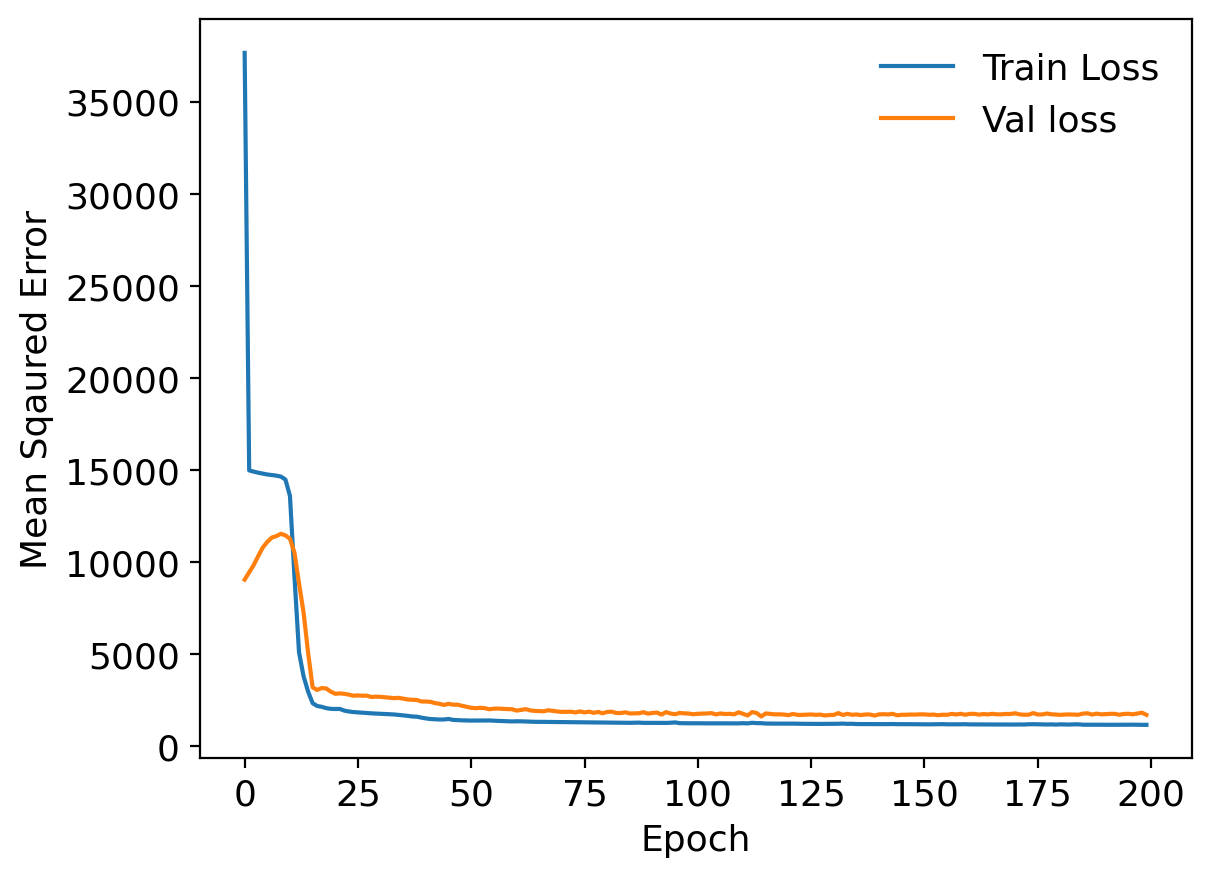

In [13]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Sqaured Error')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()
    
    
plot_history(history)

### 4. evaluate the model performance

Let's test the reconstruction capabilities of our VAE model on the test set.

In [14]:
z = encoder_model.predict(y_test)
y_test_pre = decoder_model.predict([z,X_test])

y_test_pre = y_test_pre*std + mean

y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 96, 144)
y_test_pre = xr.Dataset(coords={'time': y_test_xr.time.values, 
                               'latitude': y_test_xr.latitude.values, 
                               'longitude': y_test_xr.longitude.values},
                       data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pre)))

/opt/anaconda3/envs/keras/lib/python3.10/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Comparisons in terms of the spatial distribution

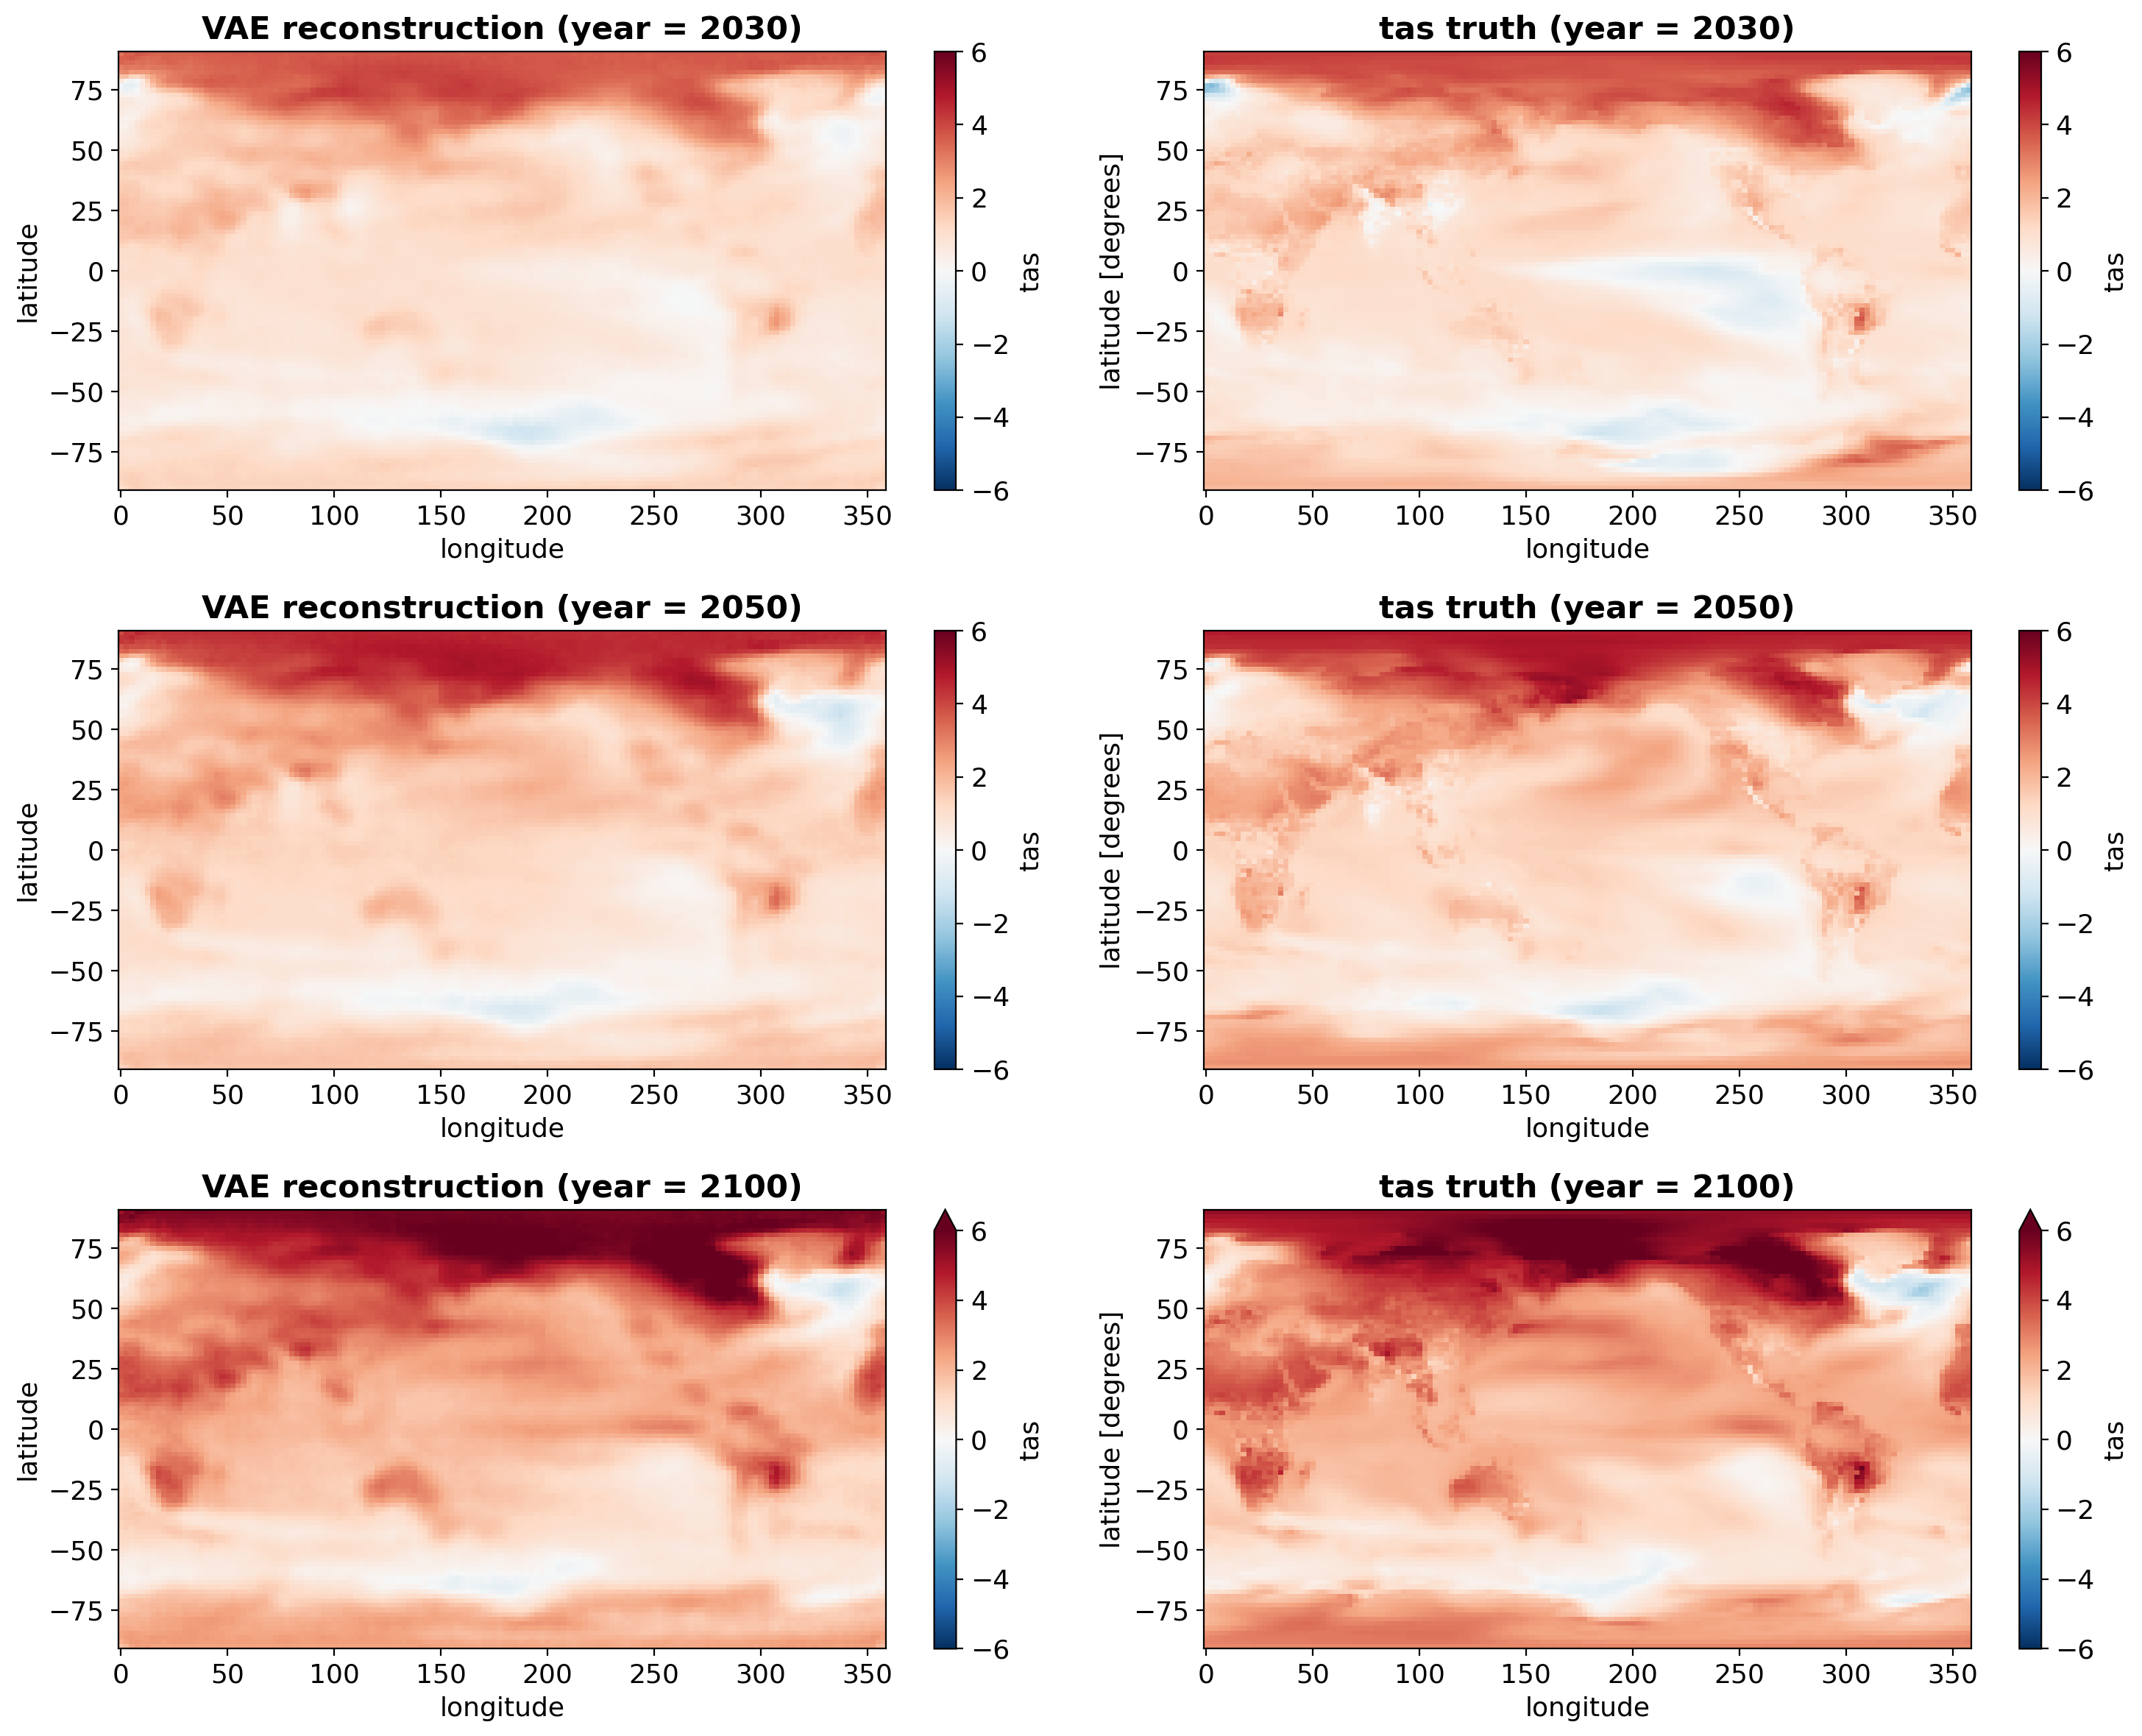

In [15]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'VAE reconstruction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()

Comparisons in terms of the temporal variability (under the ssp245 scenario)

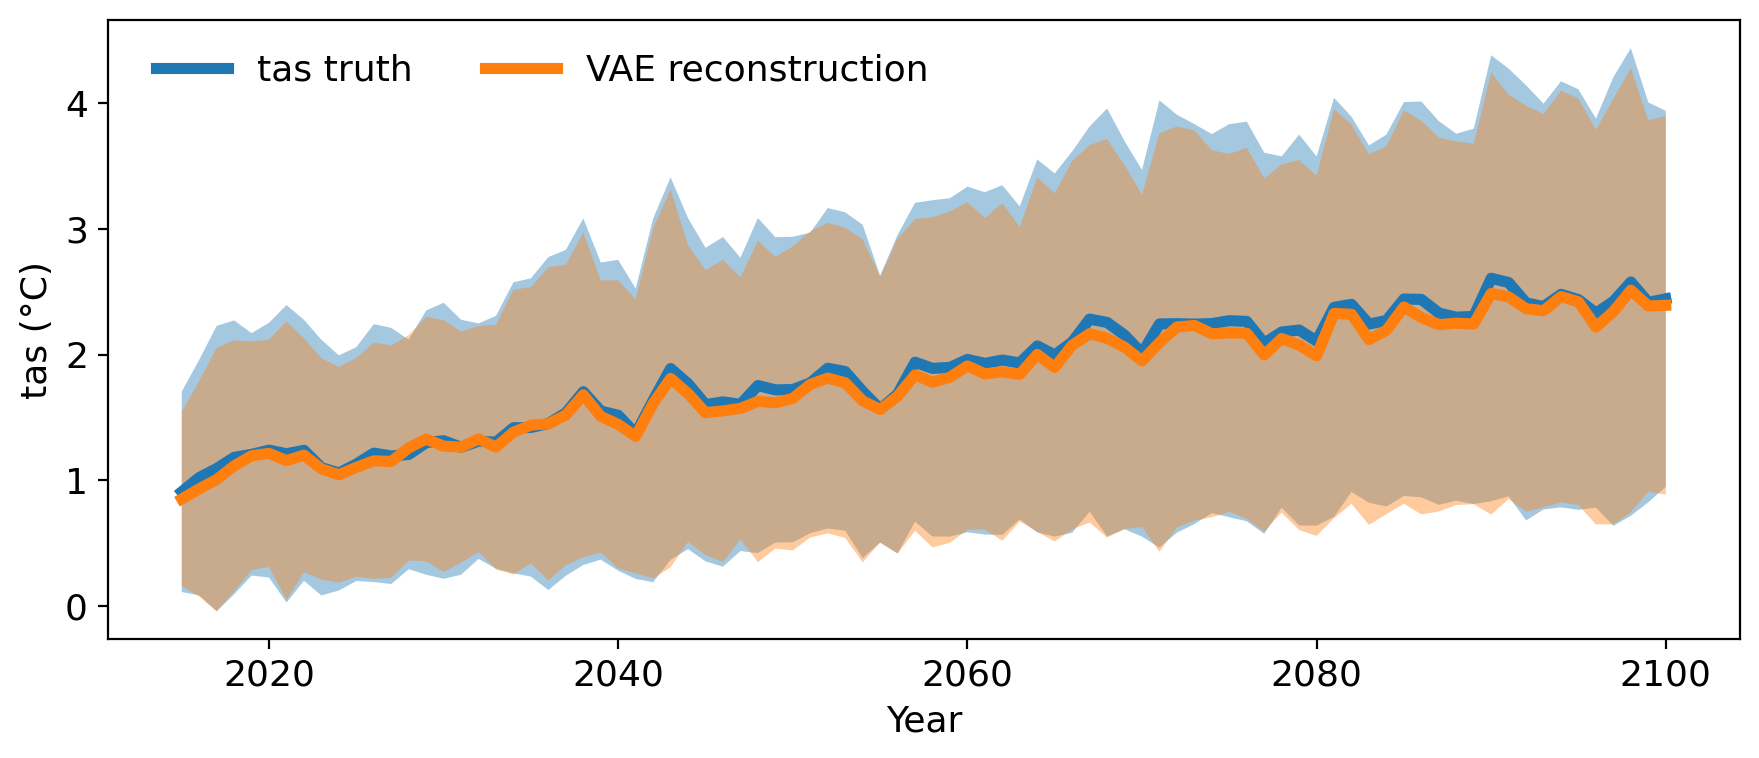

In [16]:
fig, ax = plt.subplots(figsize=(9,4))

yr,mean_truth = mean_std_plot(y_test_xr['tas'],color='tab:blue',label='tas truth',ax=ax)
yr,mean_pre   = mean_std_plot(y_test_pre['tas'],color='tab:orange',label='VAE reconstruction',ax=ax)

ax.set_xlabel('Year')
ax.set_ylabel('tas (°C)')


fig.legend(loc='upper left',bbox_to_anchor=(0.08,0.95),ncol=2)


plt.tight_layout()